# sequence prediction sandbox


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [4]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [5]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

seq   score
0  AAAAAAAA  20.000
1  AAAAAAAC  19.625
2  AAAAAAAG  19.250
3  AAAAAAAT  18.875
4  AAAAAACA  19.625

In [7]:
mer8_motif = score_seqs_motif(seqs8)


In [8]:
mer8_motif[mer8['seq']=='TGCGTTTT']

seq  score
59135  TGCGTTTT    2.5

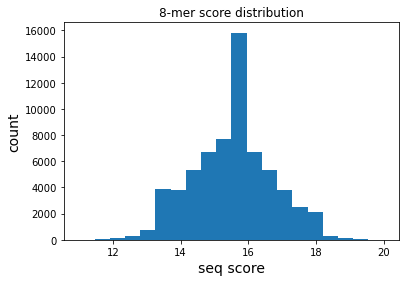

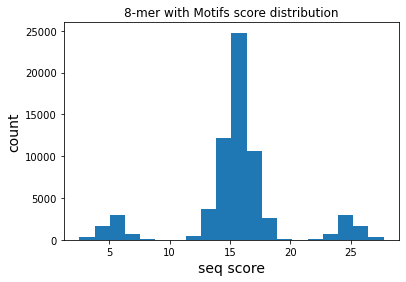

In [9]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [10]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        
        #print("og shape?",xb.shape)
        #xb = xb.flatten()
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        #print("flattened shape?",xb.shape)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out



In [11]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()


def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        #u.quick_seq_pred(model, seqs, oracle)
        quick_seq_pred(model, seqs, oracle)
        print()

## try defining flexible model class with Optuna

In [12]:
# defining a deep linear model with Optuna
class DNA_Linear_Opt(nn.ModuleList):
    def __init__(self, trial, seq_len):
        super().__init__()
        
        self.seq_len = seq_len
        # Where the layers and dropouts will be stacked
        self.layers = []
        self.dropouts = []
        
        # Given a trial, takes the suggested number of 
        # layers as well as the dropout value  
        n_layers = trial.suggest_int('n_layers', 1, 3)
        dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
        # QUESTION: Can this be moved out?
        
        # input sequence size
        input_dim = 4*seq_len
        
        # Given the suggested number of layers, proceeds by
        # stacking layer by layer. Likewise the number of internal
        # units is a value taken from the current trial suggestion
        for layer in range(n_layers):
            output_dim = trial.suggest_int(f"output_dim_{layer}", 1, 100)#, log=True)
            
            self.layers.append(nn.Linear(input_dim, output_dim))
            self.dropouts.append(nn.Dropout(dropout))

            input_dim = output_dim
        
        # The last layer is added to the stack.
        self.layers.append(nn.Linear(input_dim, 1))
        self.dropouts.append(nn.Dropout(0)) # IDENTITY - use for balanced for loop in forward()
        
        
        # PyTorch needs each layer, dropout, etc to be defined as an instance 
        # variable of the class. E.g. self.layer_1 = nn.Linear(in, out)
        # Thus we need to create such instance variable from the list of stacked 
        # layers and dropouts with the "setattr" method.
        for idx, layer in enumerate(self.layers):
            setattr(self, f"fc_{idx}", layer)

        for idx, dropout in enumerate(self.dropouts):
            setattr(self, f"dr_{idx}", dropout)
            
    def forward(self, xb):

        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        
        x = xb #?
        
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = F.relu(x)
            x = dropout(x)
        
        #out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return x

In [ ]:
# class DNA_CNN_Opt(nn.Module):
#     def __init__(self,
#                  trial
#                  seq_len,
#                  num_filters=31,
#                  kernel_size=3
#                 ):
#         super().__init__()
#         self.seq_len = seq_len

#         # Where the layers and dropouts will be stacked
#         self.conv_layers = []
#         self.dropouts = []
        
#         # TODO: ah how ot search over CNN configs?
#         # ******
        
#         # Given a trial, takes the suggested number of 
#         # layers as well as the dropout value  
#         n_layers = trial.suggest_int('n_layers', 1, 3)
#         dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
        
#         self.conv_net = nn.Sequential(
#             nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
#             # ^^ changed from 4 to 1 channel??
#             nn.ReLU(inplace=True),
#             nn.Flatten(),
#             nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
#             nn.ReLU(inplace=True),
#             nn.Linear(10, 1),
#         ) 

#     def forward(self, xb):
#         # reshape view to batch_ssize x 4channel x seq_len
#         # permute to put channel in correct order
#         #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
#         #xb = xb.permute(0,2,1) 
#         # OHE FIX??
#         xb = xb.permute(0,2,1).unsqueeze(1)
#         # ^^ Conv2D input fix??
#         #print(xb.shape)
#         out = self.conv_net(xb)
#         #print("CNN out shape:",out.shape)
#         return out

# Try with 8 mers

# Single task Regression with Motifs
### Linear Model

In [13]:
# mer8motif_train_df.to_csv("mer8motif_train_df.tsv",sep='\t')
# mer8motif_test_df.to_csv("mer8motif_test_df.tsv",sep='\t')

In [14]:
#mer8motif_train_df.head()

In [13]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

In [14]:
mer8motif_train_df['oh'].values[0].shape

(8, 4)

In [15]:
# # inspect some stuff about a batch
# for xb, yb in mer8motif_train_dl:
#     break
    
# print(xb)
# print(xb.permute(0,2,1).unsqueeze(1).shape)
# xb.permute(0,2,1)

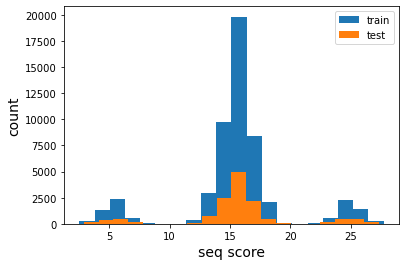

In [16]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

# TEMP FUNCS

In [17]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

## Optuna objective functions
study.optimize seems to only take trial as an input and automatically. In order to pass epochs and train/test data loaders, I think I have to wrap it in an extra Model class? Then calls the Model's self.objective?

In [18]:
class OptWrap:
    '''
    Adapted from: 
    https://github.com/FernandoLpz/Optuna-Sklearn-PyTorch/blob/master/optuna_pytorch.py
    
    Optuna needs to call "study.optimize" on a function with no inputs other 
    than trial... trying to make that happen here...
    '''
    
    def __init__(self, 
                 name, 
                 model_class, 
                 seq_len, 
                 epochs, 
                 loss_func, 
                 train_loader, 
                 test_loader
                ):
        self.name = name
        self.model_class = model_class
        self.seq_len = seq_len
        self.epochs = epochs
        self.loss_func = loss_func
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_loss_list = []
        self.test_loss_list = []
        self.trial_count = 0
        self.best_train_loss = None
        self.best_test_loss = None
        self.best_model = None
        
    def optimize(self, trial):
        self.trial_count += 1 # increments with trials run for this model
        # Initialize model with the current trial
        model = self.model_class(trial, self.seq_len).to(device)
        train_losses = []
        test_losses = []
        # ^^ collect per trial
        
        # Define space search for training settings
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = train_step(model, self.train_loader, loss_func, opt)
            
            test_loss = val_step(model, self.test_loader, loss_func)
            print(epoch, test_loss)
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            # decide if trial should be pruned
            trial.report(test_loss, epoch)
            if trial.should_prune():
                # add partial trials to the train history
                self.train_loss_list.append(train_losses)
                self.test_loss_list.append(test_losses)
                
                raise optuna.exceptions.TrialPruned()
                
        
        # return history of this trials training/test loss?
        self.train_loss_list.append(train_losses)
        self.test_loss_list.append(test_losses)
        
        # return final test loss?? or best test loss?? 
        # TODO/QUESTION: try best test loss instead of final
        # CALLBACKS?
        return test_loss
    
    def retrain_best(self, trial):
        '''
        Use a Frozen trial to retrain/return a model with the 
        best hyperparameters
        '''
        assert(type(trial) == optuna.trial.FrozenTrial)
        
        model = self.model_class(trial, self.seq_len).to(device)
        train_losses = []
        test_losses = []
        
        # Define space search for training settings
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        opt = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
        # Starts training phase
        for epoch in range(self.epochs):
            train_loss = train_step(model, self.train_loader, loss_func, opt)
            
            test_loss = val_step(model, self.test_loader, loss_func)
            print(epoch, test_loss)
            
            # keep track of these for plotting loss by epoch later
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        # Update history for current best
        if self.best_model is not None:
            print("Warning: overwriting best model with new best model")
        self.best_train_loss = train_losses
        self.best_test_loss = test_losses
        self.best_model = model
        
        return model
            
        
        



## Shallow Linear

0 12.715557681521084
1 12.783323152020897
2 12.734936251140493
3 12.764558474683602
4 12.74848120386076
5 12.778671091072873
6 12.805366783815803
7 12.832193931992693
8 12.811170843377287
9 12.759117247438445
10 12.745986385828553
11 12.739899861547036
12 12.745567814338706
13 12.750006669617878
14 12.813900921306196
15 12.71379340740832
16 12.812225694259128
17 12.74696354874031
18 12.744609147446672
19 12.800106964716651


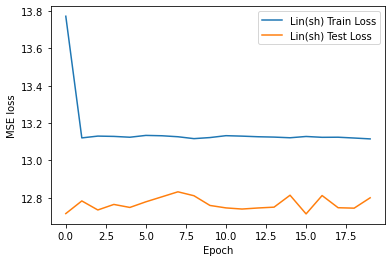

In [19]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)
mer8motif_model_lin_s.to(device)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [20]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_lin_s(dna_oh)

tensor([[7.1737]], device='cuda:0', grad_fn=<AddmmBackward>)

In [21]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:23.488 actual:20.000 (-3.488)
CCCCCCCC: pred:13.459 actual:17.000 (3.541)
GGGGGGGG: pred:7.174 actual:14.000 (6.826)
TTTTTTTT: pred:17.870 actual:11.000 (-6.870)

AACCAACA: pred:18.648 actual:18.875 (0.227)
CCGGCGCG: pred:9.846 actual:5.500 (-4.346)
GGGTAAGG: pred:14.225 actual:15.125 (0.900)
TTTCGTTT: pred:14.464 actual:12.125 (-2.339)
TGTAATAC: pred:19.803 actual:15.500 (-4.303)

TATAAAAA: pred:22.395 actual:27.750 (5.355)
CCTATCCC: pred:17.243 actual:25.875 (8.632)
GTATGGGG: pred:12.543 actual:24.000 (11.457)
TTTATTTT: pred:18.530 actual:22.125 (3.595)

AAGCGAAA: pred:16.284 actual:8.125 (-8.159)
CGCGCCCC: pred:12.470 actual:6.250 (-6.220)
GGGCGGGG: pred:7.959 actual:4.375 (-3.584)
TTGCGTTT: pred:12.406 actual:2.500 (-9.906)

ATATGCGA: pred:15.992 actual:15.875 (-0.117)
TGCGTATT: pred:14.510 actual:13.625 (-0.885)



## Deep Linear

0 8.272559353771973
1 3.5149035365626258
2 2.8128727496779833
3 1.9496769500935553
4 1.3819364458208845
5 1.082764689617034
6 2.9127172916254547
7 1.0028048738653081
8 0.9672642074307091
9 0.9070514113820468
10 0.8056273113925955
11 0.704881577279338
12 0.7585197929878369
13 0.6615428427733915
14 0.6900376021096964
15 0.7954029229639833
16 0.6003732748788906
17 0.7358807694731888
18 0.6347096568137762
19 0.6179884366485352


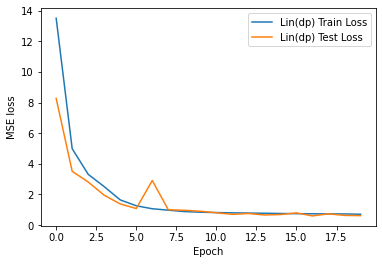

In [22]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)
mer8motif_model_lin_d.to(device)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [23]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_lin_d(dna_oh)

tensor([[14.1225]], device='cuda:0', grad_fn=<ReluBackward1>)

In [24]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:19.418 actual:20.000 (0.582)
CCCCCCCC: pred:17.354 actual:17.000 (-0.354)
GGGGGGGG: pred:14.123 actual:14.000 (-0.123)
TTTTTTTT: pred:12.445 actual:11.000 (-1.445)

AACCAACA: pred:19.225 actual:18.875 (-0.350)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.089 actual:15.125 (0.036)
TTTCGTTT: pred:11.997 actual:12.125 (0.128)
TGTAATAC: pred:16.014 actual:15.500 (-0.514)

TATAAAAA: pred:26.474 actual:27.750 (1.276)
CCTATCCC: pred:27.687 actual:25.875 (-1.812)
GTATGGGG: pred:23.166 actual:24.000 (0.834)
TTTATTTT: pred:19.790 actual:22.125 (2.335)

AAGCGAAA: pred:7.904 actual:8.125 (0.221)
CGCGCCCC: pred:6.106 actual:6.250 (0.144)
GGGCGGGG: pred:4.632 actual:4.375 (-0.257)
TTGCGTTT: pred:3.846 actual:2.500 (-1.346)

ATATGCGA: pred:15.728 actual:15.875 (0.147)
TGCGTATT: pred:12.764 actual:13.625 (0.861)



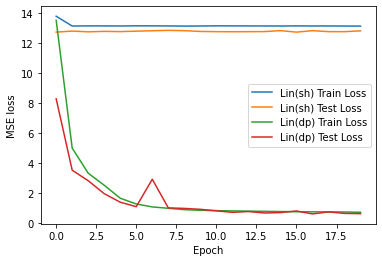

In [25]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

## Optuna model

In [26]:
seq_len = len(mer8motif_train_df['seq'].values[0])
eps=20
loss_func = torch.nn.MSELoss()

ow = OptWrap(
    "DNA_Linear_Opt",
    DNA_Linear_Opt,
    seq_len,
    eps,
    loss_func,
    mer8motif_train_dl, 
    mer8motif_test_dl
)

In [27]:
ow.trial_count

0

In [28]:
study = optuna.create_study(direction="minimize")

[I 2021-09-21 18:24:27,627] A new study created in memory with name: no-name-3b2f826c-31d7-4d67-b6b9-587300cb9ae6


In [29]:
study.optimize(ow.optimize, n_trials=20)

0 13.447509266833979
1 12.5736526311226
2 12.300858802281759
3 11.863428658961814
4 11.374691054256798
5 10.868357894740383
6 10.436952594225458
7 10.01263850695446
8 9.662028292311668
9 9.360221157250042
10 9.131617105394593
11 8.848880583087881
12 8.6230761844791
13 8.467065432757767
14 8.308362062871547
15 8.108242036058003
16 7.97447888267124
17 7.82228460205849
18 7.71477757267447


[I 2021-09-21 18:26:12,263] Trial 0 finished with value: 7.606341696363926 and parameters: {'n_layers': 1, 'dropout': 0.13594889864819143, 'output_dim_0': 97, 'optimizer': 'Adam', 'lr': 8.87730339587269e-05}. Best is trial 0 with value: 7.606341696363926.


19 7.606341696363926
0 4.904672910449961
1 1.6511453557049025
2 2.2961158392621788
3 2.5913233218437783
4 2.1923991745280436
5 1.7792348296273253
6 3.9241576005827192
7 2.9222185287441573
8 3.0850491666774724
9 3.1249306874942553
10 3.0011802683375506
11 3.5144167305196263
12 4.0942291679178515
13 2.3997482006308197
14 5.378318120988906
15 4.030540439378963
16 4.588409567177341
17 3.5167736563277945
18 3.9022252808450326


[I 2021-09-21 18:28:26,754] Trial 1 finished with value: 3.627437189244118 and parameters: {'n_layers': 3, 'dropout': 0.39411003041703074, 'output_dim_0': 83, 'output_dim_1': 81, 'output_dim_2': 80, 'optimizer': 'RMSprop', 'lr': 0.005070169287945879}. Best is trial 1 with value: 3.627437189244118.


19 3.627437189244118
0 9.522376025758904
1 9.664990285542777
2 10.341872740112903
3 9.38354329043203
4 9.273592464941865
5 9.89475779321305
6 10.523876382368238
7 11.169760534284608
8 11.873023733889998
9 10.303899408203002
10 10.136500928872673
11 9.760139900794254
12 10.478911959667068
13 10.020787830260202
14 9.973889184388712
15 9.538447530532633
16 11.05976761679279
17 10.240719197261686
18 10.210756592550291


[I 2021-09-21 18:30:05,038] Trial 2 finished with value: 9.96665055279074 and parameters: {'n_layers': 1, 'dropout': 0.4159781609151332, 'output_dim_0': 43, 'optimizer': 'Adam', 'lr': 0.05936279301160098}. Best is trial 1 with value: 3.627437189244118.


19 9.96665055279074
0 12.596864083854026
1 11.566121029369999
2 10.42841922562043
3 9.656468333450803
4 8.943037575597911
5 8.399234787716457
6 8.063831855501748
7 7.742981137745912
8 7.447509612493628
9 7.043500526680028
10 6.717785487523849
11 6.246030669269454
12 6.184985081297179
13 5.409579549579312
14 5.001973829956581
15 4.46676776735274
16 3.848192398336045
17 3.1233651664404745
18 2.8551332839276684


[I 2021-09-21 18:32:10,319] Trial 3 finished with value: 2.454340374077334 and parameters: {'n_layers': 2, 'dropout': 0.24028130162009426, 'output_dim_0': 88, 'output_dim_1': 87, 'optimizer': 'Adam', 'lr': 0.0001638994207151616}. Best is trial 3 with value: 2.454340374077334.


19 2.454340374077334
0 3.5952383527463443
1 5.24048737760066
2 7.334342448668925
3 6.536547781105518
4 8.87679449771467
5 12.372978881569871
6 10.876016616307457
7 8.579939348535055
8 7.636100547571789
9 8.451193696256814
10 10.11837348208709
11 8.42222573146847
12 10.253523316967586
13 9.947721612050579
14 8.687781931856874
15 7.968057661234587
16 8.73147770130838
17 7.049585931187255
18 9.234682479477126


[I 2021-09-21 18:34:00,168] Trial 4 finished with value: 8.899130770813265 and parameters: {'n_layers': 3, 'dropout': 0.1370651237596121, 'output_dim_0': 56, 'output_dim_1': 19, 'output_dim_2': 83, 'optimizer': 'SGD', 'lr': 0.03026143281462391}. Best is trial 3 with value: 2.454340374077334.


19 8.899130770813265


[I 2021-09-21 18:34:07,871] Trial 5 pruned. 


0 13.222077090655809


[I 2021-09-21 18:34:14,467] Trial 6 pruned. 


0 18.683879121142187


[I 2021-09-21 18:34:19,518] Trial 7 pruned. 


0 12.767770063969868


[I 2021-09-21 18:34:24,917] Trial 8 pruned. 


0 14.56620319555964


[I 2021-09-21 18:34:29,754] Trial 9 pruned. 


0 258.5624000844993


[I 2021-09-21 18:34:35,948] Trial 10 pruned. 


0 178.82967133779587
0 2.139798548210129
1 2.1728101351506144
2 1.3534487577829923
3 1.2488929700250755
4 1.3222904182498183
5 1.9817476619409014
6 1.4647397387671623
7 1.7380138316348326
8 1.6998740717436724
9 1.9150165206842809
10 1.8383287489186855
11 2.3725761028315313
12 2.272148824357995
13 2.918735590373184
14 3.838409142590875
15 1.9521536522129705
16 2.097076806597023
17 2.534162735454522
18 2.3376291665701303


[I 2021-09-21 18:36:27,323] Trial 11 finished with value: 2.507931218957452 and parameters: {'n_layers': 2, 'dropout': 0.32818793646478267, 'output_dim_0': 91, 'output_dim_1': 100, 'optimizer': 'RMSprop', 'lr': 0.005364074863694609}. Best is trial 3 with value: 2.454340374077334.


19 2.507931218957452
0 3.3237907458795872
1 1.6273695908357249
2 1.1457370945858107
3 1.0466775124302026
4 0.8753356610163069
5 0.8087655455317391
6 1.5717763080863298
7 1.5497648603270648
8 2.1673586735428563
9 0.672421388082811
10 1.0289141553731764
11 0.8856137646404816
12 1.1654832783386198
13 1.0116556080022407
14 1.1392126146591415
15 1.02283615849487
16 1.338224252851877
17 2.053842969706551
18 1.473327591330345


[I 2021-09-21 18:38:19,646] Trial 12 finished with value: 0.9050421147468861 and parameters: {'n_layers': 2, 'dropout': 0.31173396867942504, 'output_dim_0': 95, 'output_dim_1': 99, 'optimizer': 'RMSprop', 'lr': 0.004051041179865816}. Best is trial 12 with value: 0.9050421147468861.


19 0.9050421147468861


[I 2021-09-21 18:38:25,421] Trial 13 pruned. 


0 11.114635842563832


[I 2021-09-21 18:38:30,957] Trial 14 pruned. 


0 7.155487870047796


[I 2021-09-21 18:38:37,168] Trial 15 pruned. 


0 12.356898232444161


[I 2021-09-21 18:38:41,723] Trial 16 pruned. 


0 235.7669040867931
0 3.4467348164816545
1 2.977416998267101
2 1.1871860669991174
3 1.453482050358849
4 1.5657353714150528
5 1.6949239273725814
6 1.9944166621641757
7 1.6750096901728315
8 1.390044478962734
9 2.141943033523164
10 1.801908528321412
11 2.332966468338154
12 1.5319104074640613
13 1.5682460581466013
14 1.5667252105705924
15 1.8021411455026353
16 1.8570552347856013
17 1.3663140759463168
18 2.3147101791625


[I 2021-09-21 18:40:46,649] Trial 17 finished with value: 2.106636482494695 and parameters: {'n_layers': 2, 'dropout': 0.24733009170016285, 'output_dim_0': 81, 'output_dim_1': 93, 'optimizer': 'Adam', 'lr': 0.017242433468909052}. Best is trial 12 with value: 0.9050421147468861.


19 2.106636482494695
0 3.014083362415519
1 3.376598429786275
2 6.598645890942699
3 3.976112325982437
4 5.748948738249493
5 3.27563511226798
6 2.8946066682690486
7 4.014232860825249
8 2.704399765970178
9 2.938717944702707
10 1.9742136804542147
11 3.1127245770389345
12 4.888293465193012
13 4.423296628163506
14 4.686907389047472
15 3.2097956474698788
16 3.4563640766709742
17 3.0189984098149574
18 3.423759039498236


[I 2021-09-21 18:42:37,980] Trial 18 finished with value: 3.7775534018487655 and parameters: {'n_layers': 2, 'dropout': 0.3400551883711997, 'output_dim_0': 77, 'output_dim_1': 46, 'optimizer': 'RMSprop', 'lr': 0.019241804855473936}. Best is trial 12 with value: 0.9050421147468861.


19 3.7775534018487655


[I 2021-09-21 18:42:41,682] Trial 19 pruned. 


0 258.5624000844993


In [30]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  11
  Number of complete trials:  9
Best trial:
  Value:  0.9050421147468861
  Params: 
    n_layers: 2
    dropout: 0.31173396867942504
    output_dim_0: 95
    output_dim_1: 99
    optimizer: RMSprop
    lr: 0.004051041179865816


In [31]:
optuna.visualization.plot_optimization_history(study)

In [32]:
optuna.visualization.plot_param_importances(study)

In [33]:
optuna.visualization.plot_slice(study)

In [34]:
optuna.visualization.plot_parallel_coordinate(study)

### Why doesn't this plot show all trials in the study?

In [35]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration'], axis=1)
df

number       value  params_dropout  params_lr  params_n_layers  \
0        0    7.606342        0.135949   0.000089                1   
1        1    3.627437        0.394110   0.005070                3   
2        2    9.966651        0.415978   0.059363                1   
3        3    2.454340        0.240281   0.000164                2   
4        4    8.899131        0.137065   0.030261                3   
5        5   13.222077        0.442824   0.007131                3   
6        6   18.683879        0.174276   0.000083                3   
7        7   12.767770        0.445516   0.000391                1   
8        8   14.566203        0.410480   0.000056                3   
9        9  258.562400        0.213012   0.000905                2   
10      10  178.829671        0.282375   0.000010                2   
11      11    2.507931        0.328188   0.005364                2   
12      12    0.905042        0.311734   0.004051                2   
13      13   11.114636        0.270262   0.000502                2   
14      14    7.155488        0.340701   0.002435                2   
15      15   12.356898        0.228213   0.000216                2   
16      16  235.766904        0.490648   0.000015                1   
17      17    2.106636        0.247330   0.017242                2   
18      18    3.777553        0.340055   0.019242                2   
19      19  258.562400        0.304696   0.094803                1   

   params_optimizer  params_output_dim_0  params_output_dim_1  \
0              Adam                   97                  NaN   
1           RMSprop                   83                 81.0   
2              Adam                   43                  NaN   
3              Adam                   88                 87.0   
4               SGD                   56                 19.0   
5              Adam                    6                 66.0   
6           RMSprop                   54                  2.0   
7              Adam                   60                  NaN   
8               SGD                   75                 75.0   
9               SGD                   67                 26.0   
10             Adam                   31                 99.0   
11          RMSprop                   91                100.0   
12          RMSprop                   95                 99.0   
13          RMSprop                   99                 50.0   
14          RMSprop                   74                 87.0   
15             Adam                   87                 56.0   
16          RMSprop                   20                  NaN   
17             Adam                   81                 93.0   
18          RMSprop                   77                 46.0   
19              SGD                   45                  NaN   

    params_output_dim_2  
0                   NaN  
1                  80.0  
2                   NaN  
3                   NaN  
4                  83.0  
5                  52.0  
6                  67.0  
7                   NaN  
8                  89.0  
9                   NaN  
10                  NaN  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN

In [56]:
study.trials_dataframe()

number       value             datetime_start          datetime_complete  \
0        0    7.606342 2021-09-21 18:24:32.662904 2021-09-21 18:26:12.263056   
1        1    3.627437 2021-09-21 18:26:12.264087 2021-09-21 18:28:26.754039   
2        2    9.966651 2021-09-21 18:28:26.755150 2021-09-21 18:30:05.038172   
3        3    2.454340 2021-09-21 18:30:05.039352 2021-09-21 18:32:10.318684   
4        4    8.899131 2021-09-21 18:32:10.319855 2021-09-21 18:34:00.168149   
5        5   13.222077 2021-09-21 18:34:00.169323 2021-09-21 18:34:07.871806   
6        6   18.683879 2021-09-21 18:34:07.872556 2021-09-21 18:34:14.467655   
7        7   12.767770 2021-09-21 18:34:14.468438 2021-09-21 18:34:19.518091   
8        8   14.566203 2021-09-21 18:34:19.518880 2021-09-21 18:34:24.917312   
9        9  258.562400 2021-09-21 18:34:24.918117 2021-09-21 18:34:29.754494   
10      10  178.829671 2021-09-21 18:34:29.755305 2021-09-21 18:34:35.948938   
11      11    2.507931 2021-09-21 18:34:35.949837 2021-09-21 18:36:27.323586   
12      12    0.905042 2021-09-21 18:36:27.324591 2021-09-21 18:38:19.645849   
13      13   11.114636 2021-09-21 18:38:19.646844 2021-09-21 18:38:25.421842   
14      14    7.155488 2021-09-21 18:38:25.422529 2021-09-21 18:38:30.957086   
15      15   12.356898 2021-09-21 18:38:30.957787 2021-09-21 18:38:37.168355   
16      16  235.766904 2021-09-21 18:38:37.169066 2021-09-21 18:38:41.723670   
17      17    2.106636 2021-09-21 18:38:41.724352 2021-09-21 18:40:46.648863   
18      18    3.777553 2021-09-21 18:40:46.649924 2021-09-21 18:42:37.979910   
19      19  258.562400 2021-09-21 18:42:37.980995 2021-09-21 18:42:41.682570   

                 duration  params_dropout  params_lr  params_n_layers  \
0  0 days 00:01:39.600152        0.135949   0.000089                1   
1  0 days 00:02:14.489952        0.394110   0.005070                3   
2  0 days 00:01:38.283022        0.415978   0.059363                1   
3  0 days 00:02:05.279332        0.240281   0.000164                2   
4  0 days 00:01:49.848294        0.137065   0.030261                3   
5  0 days 00:00:07.702483        0.442824   0.007131                3   
6  0 days 00:00:06.595099        0.174276   0.000083                3   
7  0 days 00:00:05.049653        0.445516   0.000391                1   
8  0 days 00:00:05.398432        0.410480   0.000056                3   
9  0 days 00:00:04.836377        0.213012   0.000905                2   
10 0 days 00:00:06.193633        0.282375   0.000010                2   
11 0 days 00:01:51.373749        0.328188   0.005364                2   
12 0 days 00:01:52.321258        0.311734   0.004051                2   
13 0 days 00:00:05.774998        0.270262   0.000502                2   
14 0 days 00:00:05.534557        0.340701   0.002435                2   
15 0 days 00:00:06.210568        0.228213   0.000216                2   
16 0 days 00:00:04.554604        0.490648   0.000015                1   
17 0 days 00:02:04.924511        0.247330   0.017242                2   
18 0 days 00:01:51.329986        0.340055   0.019242                2   
19 0 days 00:00:03.701575        0.304696   0.094803                1   

   params_optimizer  params_output_dim_0  params_output_dim_1  \
0              Adam                   97                  NaN   
1           RMSprop                   83                 81.0   
2              Adam                   43                  NaN   
3              Adam                   88                 87.0   
4               SGD                   56                 19.0   
5              Adam                    6                 66.0   
6           RMSprop                   54                  2.0   
7              Adam                   60                  NaN   
8               SGD                   75                 75.0   
9               SGD                   67                 26.0   
10             Adam                   31                 99.0   
11       

# Next:
* how do you make a new model with the "best params"?
* Confirm that I believe the best params?
* Should I be returning the BEST test loss? or just the last one of the epoch?
    * seems like it's at risk to jumps at the end that ruin it?

In [36]:
len(ow.train_loss_list)

9

In [37]:
# for i in range(len(ow.train_loss_list)):
#     print("Epoch", i)
#     d = [(ow.train_loss_list[i],"Train Loss"), (ow.test_loss_list[i], "Test Loss")]
#     u.quick_loss_plot(d)
    

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8


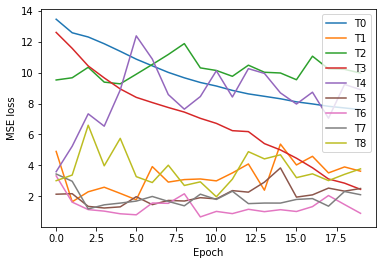

In [39]:
dd = []
for i in range(len(ow.test_loss_list)):
    print("Trial", i)
    dd += [(ow.test_loss_list[i], f"T{i}")]
u.quick_loss_plot(dd)

### Use best trial?

In [40]:
retrained_best = ow.retrain_best(study.best_trial)
retrained_best

0 3.425734255439012
1 1.028636524005292
2 1.4723156446208487
3 2.313571694797274
4 0.8549217597806248
5 0.9710812859315633
6 1.147324108531449
7 0.7124785884542958
8 0.9028400626058554
9 0.7951391286190814
10 0.8652932161842136
11 0.8405968552846933
12 1.163840796245415
13 1.5563571074637046
14 1.0388344553329658
15 1.402159528238406
16 1.1124121642009055
17 1.2928301578107397
18 1.1062092908422485
19 1.633059367839887


DNA_Linear_Opt(
  (fc_0): Linear(in_features=32, out_features=95, bias=True)
  (fc_1): Linear(in_features=95, out_features=99, bias=True)
  (fc_2): Linear(in_features=99, out_features=1, bias=True)
  (dr_0): Dropout(p=0.31173396867942504, inplace=False)
  (dr_1): Dropout(p=0.31173396867942504, inplace=False)
  (dr_2): Dropout(p=0, inplace=False)
)

In [41]:
quick_test8(retrained_best,oracle_8mer_motif)

AAAAAAAA: pred:19.559 actual:20.000 (0.441)
CCCCCCCC: pred:16.220 actual:17.000 (0.780)
GGGGGGGG: pred:13.533 actual:14.000 (0.467)
TTTTTTTT: pred:13.151 actual:11.000 (-2.151)

AACCAACA: pred:17.355 actual:18.875 (1.520)
CCGGCGCG: pred:6.945 actual:5.500 (-1.445)
GGGTAAGG: pred:14.934 actual:15.125 (0.191)
TTTCGTTT: pred:13.170 actual:12.125 (-1.045)
TGTAATAC: pred:15.466 actual:15.500 (0.034)

TATAAAAA: pred:24.512 actual:27.750 (3.238)
CCTATCCC: pred:22.390 actual:25.875 (3.485)
GTATGGGG: pred:20.299 actual:24.000 (3.701)
TTTATTTT: pred:17.614 actual:22.125 (4.511)

AAGCGAAA: pred:8.812 actual:8.125 (-0.687)
CGCGCCCC: pred:6.256 actual:6.250 (-0.006)
GGGCGGGG: pred:4.870 actual:4.375 (-0.495)
TTGCGTTT: pred:8.950 actual:2.500 (-6.450)

ATATGCGA: pred:14.961 actual:15.875 (0.914)
TGCGTATT: pred:16.824 actual:13.625 (-3.199)



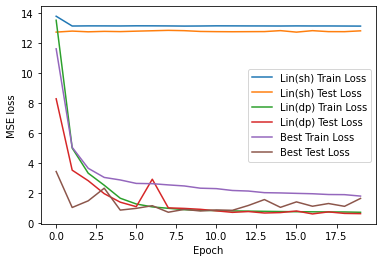

In [42]:
d = [(ow.best_train_loss,"Best Train Loss"), (ow.best_test_loss, "Best Test Loss")]
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    d)

### CNN Model

0 0.45365984201033965
1 0.11009781747993319
2 0.08320063156174393
3 0.024859992419807186
4 0.020041678033238104
5 0.011208865270323559
6 0.04851500042757519
7 0.012669194277420272
8 0.008020521747595804
9 0.04132280512018738
10 0.008575784054937991
11 0.006425556217738641
12 0.007532110968067546
13 0.004595538359767201
14 0.018227173066915427
15 0.007744885511811404
16 0.0037388621335226768
17 0.0036954546821159114
18 0.0034930385912497557
19 0.007318497444983662


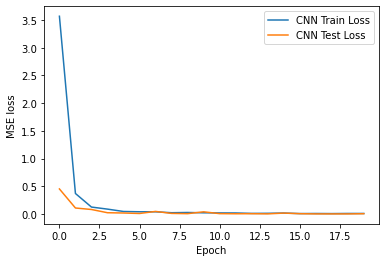

In [43]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)
mer8motif_model_cnn.to(device)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
    lr=0.01
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [142]:
class DNA_CNN2(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters1=31,
                 num_filters2=17,
                 kernel_size1=3,
                 kernel_size2=1,
                 pool_size1=1,
                 pool_size2=1
                ):
        super().__init__()
        self.seq_len = seq_len

        #what number goes in linear layer??
        conv1_num = np.floor((seq_len - kernel_size1 + 1)/pool_size1)
        conv2_num = np.floor((conv1_num - kernel_size2 + 1)/pool_size2)
        lin_actual = int(conv2_num * num_filters2)
        
        print('conv1_num', conv1_num)
        print('conv2_num', conv2_num)
        print('lin_actual', lin_actual)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters1, kernel_size=(4,kernel_size1)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,pool_size1)), # stride = kernel_size
            nn.Dropout(0),
            
#             # next add another layer
            nn.Conv2d(num_filters1, num_filters2, kernel_size=(1,kernel_size2)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,pool_size2)),
            nn.Dropout(0),

            # next add another layer
            nn.Flatten(),
            nn.Linear(lin_actual, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
#         print(out)
#         print(out.shape)
        
        #print("CNN out shape:",out.shape)
        return out

conv1_num 6.0
conv2_num 6.0
lin_actual 102
0 0.33233780347505404
1 0.07737964348552642
2 0.08105740572550688
3 0.04663972825710433
4 0.024851204171068546
5 0.024170587051366814
6 0.023144352436662494
7 0.029230823256477526
8 0.038305606296357604
9 0.044950274262974606
10 0.014196363094886312
11 0.08097665662444425
12 0.0276745365046449
13 0.00505891256876316
14 0.07390327400550346
15 0.005533491120613448
16 0.023649183113515455
17 0.009681418260599156
18 0.012480697349531802
19 0.006325913667591175


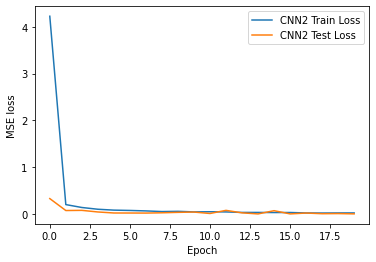

In [143]:
# attempt CNN with max pool n stuff

mer8motif_model_cnn2 = DNA_CNN2(seq_len)
mer8motif_model_cnn2.to(device)

mer8motif_train_losses_cnn2, \
mer8motif_test_losses_cnn2 = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn2, 
    lr=0.01
)

# to plot loss
mer8motif_cnn2_data_label = list(zip([mer8motif_train_losses_cnn2,mer8motif_test_losses_cnn2], ['CNN2 Train Loss','CNN2 Test Loss']))
u.quick_loss_plot(mer8motif_cnn2_data_label)

In [144]:
mer8motif_model_cnn2

DNA_CNN2(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(31, 17, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=102, out_features=10, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=10, out_features=1, bias=True)
  )
)

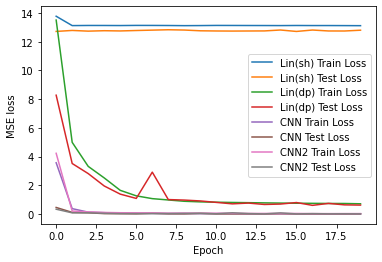

In [145]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_cnn2_data_label
)

In [52]:
dna = "GGGGGGGG"
dna_oh = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).float().to(device)
mer8motif_model_cnn(dna_oh)

tensor([[14.0533]], device='cuda:0', grad_fn=<AddmmBackward>)

In [53]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.026 actual:20.000 (-0.026)
CCCCCCCC: pred:17.047 actual:17.000 (-0.047)
GGGGGGGG: pred:14.053 actual:14.000 (-0.053)
TTTTTTTT: pred:11.110 actual:11.000 (-0.110)

AACCAACA: pred:18.959 actual:18.875 (-0.084)
CCGGCGCG: pred:5.570 actual:5.500 (-0.070)
GGGTAAGG: pred:15.130 actual:15.125 (-0.005)
TTTCGTTT: pred:12.204 actual:12.125 (-0.079)
TGTAATAC: pred:15.614 actual:15.500 (-0.114)

TATAAAAA: pred:27.743 actual:27.750 (0.007)
CCTATCCC: pred:25.868 actual:25.875 (0.007)
GTATGGGG: pred:24.071 actual:24.000 (-0.071)
TTTATTTT: pred:22.410 actual:22.125 (-0.285)

AAGCGAAA: pred:8.154 actual:8.125 (-0.029)
CGCGCCCC: pred:6.142 actual:6.250 (0.108)
GGGCGGGG: pred:4.272 actual:4.375 (0.103)
TTGCGTTT: pred:2.648 actual:2.500 (-0.148)

ATATGCGA: pred:15.828 actual:15.875 (0.047)
TGCGTATT: pred:13.569 actual:13.625 (0.056)



In [54]:
def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearShallow_8mer


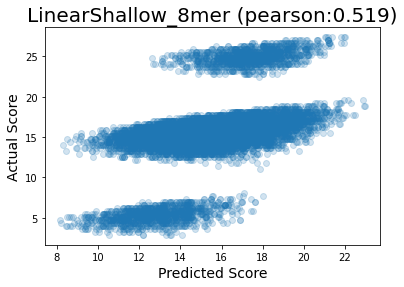

Running LinearDeep_8mer


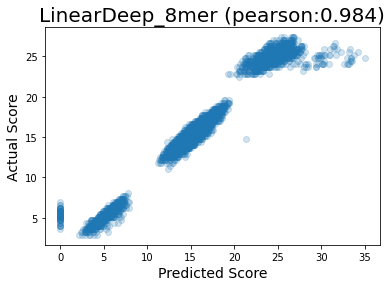

Running CNN_8mer


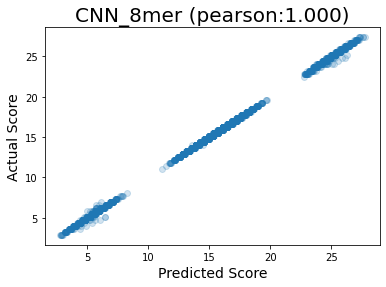

Running LinearDeep_OPT_8mer


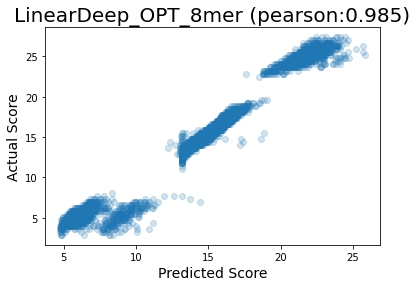

Running CNN2_8mer


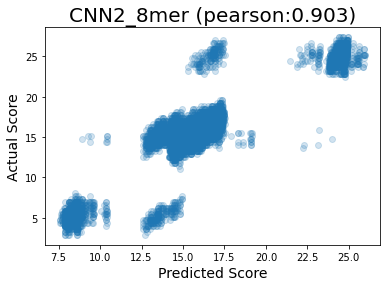

In [55]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LinearDeep_OPT_8mer",retrained_best),
    ("CNN2_8mer",mer8motif_model_cnn2),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# PAUSE

# inspect

# 8mer model cnn

In [43]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

Total convolutional layers: 1


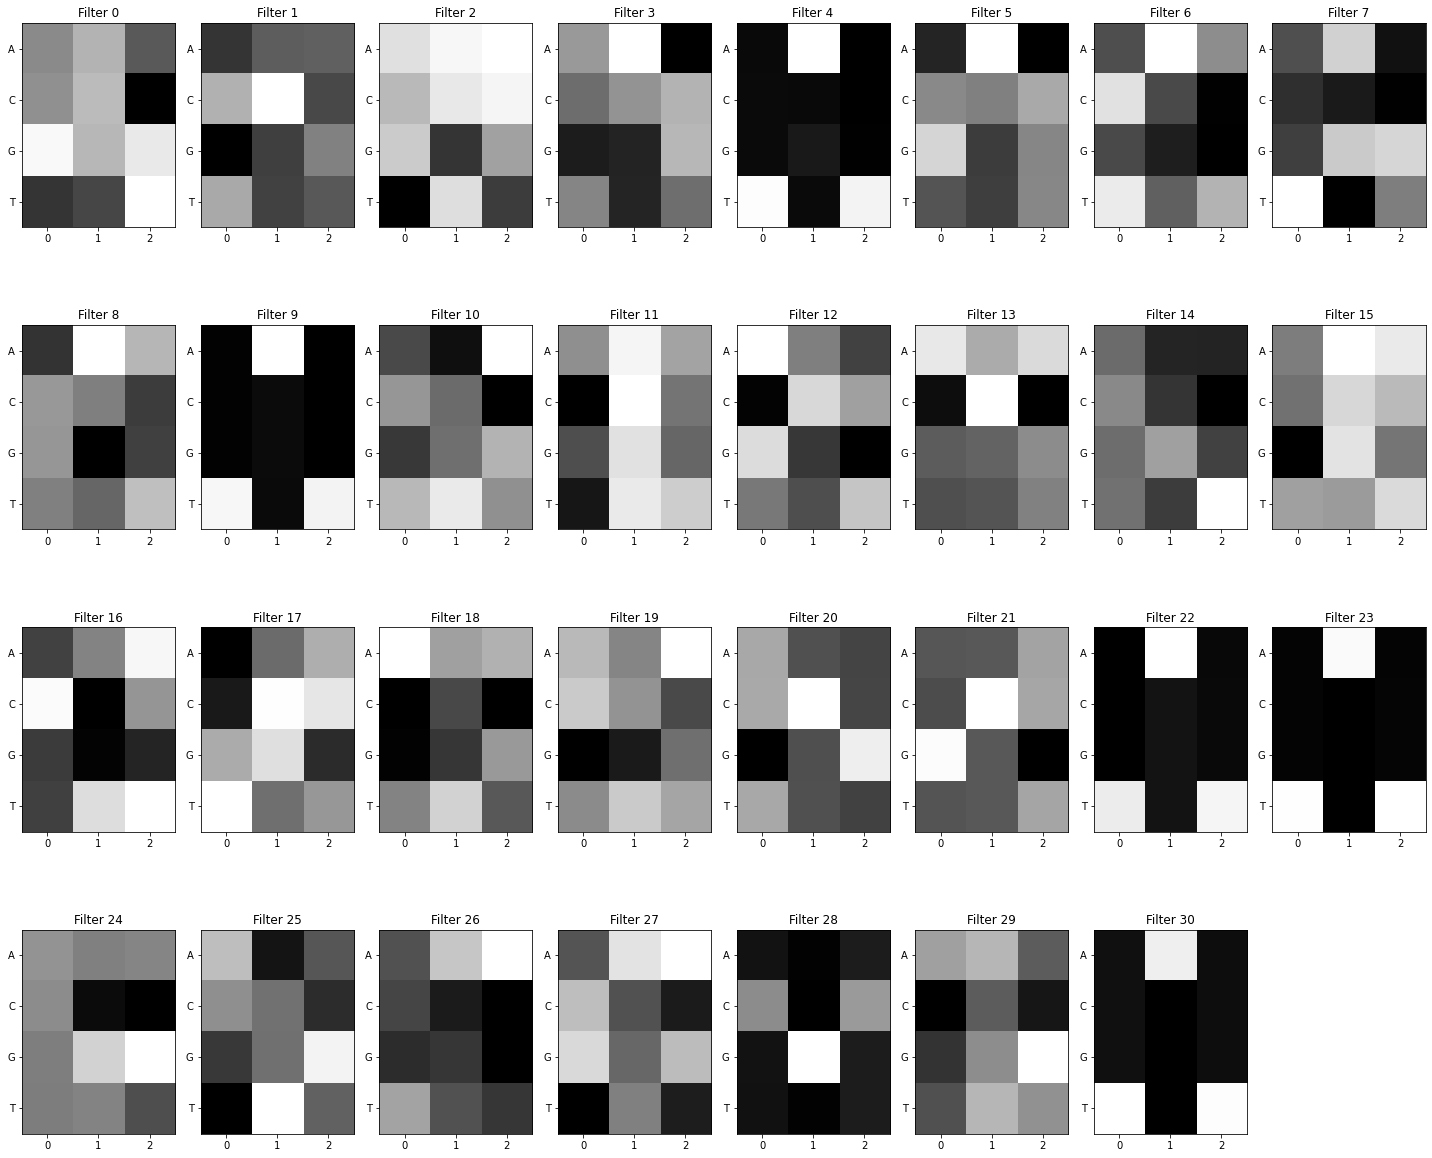

In [44]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [48]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(device)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

In [46]:
#train_seqs = list(mer8motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
seqs8_5k = u.downselect_list(seqs8,5000)

In [49]:
filter_activations = get_filter_activations(seqs8_5k, conv_layers[0])

Num filters 31
filt_width 3
Running seq AGGTCGGA
Running seq AAAAACAG
Running seq TTGTGGAG
Running seq AGCTAGGC
Running seq AACTTATA
Running seq GGCAGCCC
Running seq TTAGCCTA
Running seq GCAACGCC
Running seq ATGTCTGT
Running seq CGGCACGT
Running seq CGCCTTAC
Running seq GTAAATAA
Running seq TTGGGGCA
Running seq TAAGCAGA
Running seq GGCATCAA
Running seq GACGACAG
Running seq AATACCTA
Running seq GCGTTCGT
Running seq AGCGTACC
Running seq TGCGTCAA
Running seq AAACCTTG
Running seq TCAGCGAG
Running seq AGCAAGGT
Running seq GTATCCCA
Running seq CTAACTAA
Running seq AACAAACC
Running seq AGCGCCCA
Running seq GCTCCGTA
Running seq ACAGGCGA
Running seq TCCTGAGC
Running seq GAGTAGTG
Running seq AACCTTTA
Running seq GGGTTCCG
Running seq GGTACTGC
Running seq AGCCTTTT
Running seq TCCTCACT
Running seq CTCGCCAT
Running seq ACGTATCG
Running seq TCGGCTAT
Running seq CGGATGAT
Running seq CGCTCCGA
Running seq AAATGTCA
Running seq AAGGTTTC
Running seq GAGGAGCT
Running seq TCCCATAT
Running seq CATCTTGA
Runnin

Running seq GGGGAATA
Running seq CCTGGAAT
Running seq GGCTCAAA
Running seq GATTGCAT
Running seq CTTAGGTG
Running seq CGGCAAAT
Running seq CTGAAAAT
Running seq TAGCAGAT
Running seq CCGTCGCG
Running seq GTTACGTC
Running seq CTTTCAAA
Running seq GCCGGTAA
Running seq TAAGGGAC
Running seq AAAGCTCG
Running seq CGCTTCCC
Running seq AGCATGGA
Running seq CTATTAGG
Running seq GGCCAAGA
Running seq CACGGACT
Running seq ATCGTCTA
Running seq GGGCCTGT
Running seq CCGGATCG
Running seq AGTCGAGC
Running seq CCTGCTCT
Running seq AGGTACGA
Running seq ATTCCTTC
Running seq CCTCGTCG
Running seq CAACAGGA
Running seq TTAGCTGC
Running seq ACCGCGTG
Running seq GATCTAGT
Running seq CATGAGGT
Running seq CCGGGACC
Running seq TTCAAGGA
Running seq AGGCCTTG
Running seq CGGCTAAT
Running seq TGCTTTTC
Running seq TGGAGTTT
Running seq TGTTAGAG
Running seq TGCCAGAA
Running seq GGCACAGG
Running seq GAAGCGTG
Running seq ACACTATA
Running seq ACACGACT
Running seq CATACTTG
Running seq CTATCAAC
Running seq TCTTACGG
Running seq C

Running seq CACACATT
Running seq ATTATGGG
Running seq TAAAGCAC
Running seq AGCGACTA
Running seq CCCGAAAA
Running seq AGCTCGAA
Running seq TTGGTTAT
Running seq TACTATCT
Running seq CCATGAGA
Running seq AGGCCTGT
Running seq AGGCGAAG
Running seq GGTAAGGG
Running seq CTTTGAGT
Running seq CAGGCAGC
Running seq ACGTTAGC
Running seq TACATCTC
Running seq GGAAATGC
Running seq TTAACTCA
Running seq GGTAGCGT
Running seq TTGCTGCG
Running seq GACCGCCA
Running seq TTTAGGGT
Running seq AACAGAAG
Running seq GGGCTACT
Running seq GCTGACGT
Running seq TTTGTCCA
Running seq TTATCACT
Running seq TGATTACT
Running seq TGTAGCTT
Running seq GTGGACCC
Running seq CATCTTAT
Running seq ACGTACCG
Running seq TTTCGTTC
Running seq TCTTTCTT
Running seq GGGTTTCT
Running seq TGGGTATT
Running seq GGAGGTGG
Running seq CGTAAGGG
Running seq GACAACGG
Running seq CTAAGCTG
Running seq CCCCATAT
Running seq CTCTAGGA
Running seq AACTTCGG
Running seq CCAGTCTC
Running seq TGTCGGTA
Running seq ATGGATAC
Running seq TAGATGAT
Running seq C

Running seq CTACGTTC
Running seq AGCACAGA
Running seq GTAGTTAC
Running seq CTCAATGC
Running seq AGACGCCA
Running seq TTTGATTG
Running seq TCCCTGTG
Running seq CTGTCCCA
Running seq GGACGGCA
Running seq TGATCGGT
Running seq CCAGTTCA
Running seq GCTGGACT
Running seq CCTACGCC
Running seq GCCTACGA
Running seq TAAGATCG
Running seq TGAATCCA
Running seq GCTTTCGG
Running seq TTTCATTG
Running seq CTGAAATG
Running seq TACCACCC
Running seq GGTAACGT
Running seq CGTTTCGC
Running seq GGTCGAAT
Running seq GCCGGAGG
Running seq AACTTCCA
Running seq AGATCTGC
Running seq AGCCGCGA
Running seq ATGTCTCG
Running seq CGTGAATG
Running seq GCGGAACA
Running seq GGACCCTA
Running seq CGGCACCA
Running seq GCGAGTAG
Running seq GGTGGCAC
Running seq GGTTGGGT
Running seq ATCTGATC
Running seq CGACCCAA
Running seq TTGGTGAG
Running seq ACGTGAAT
Running seq GTGGGATG
Running seq TCTATAAC
Running seq AAGGCATC
Running seq TAAGCGTA
Running seq CATCAGGG
Running seq CACCCTTC
Running seq CACGGCGT
Running seq GTGCGATG
Running seq A

Running seq TTTTTTAG
Running seq CCGAATAG
Running seq AAGCCTGC
Running seq TTTCAACA
Running seq CGATCCCG
Running seq TGAGTCCT
Running seq TCAAAGAA
Running seq CCGAGAAT
Running seq CTTGTAGA
Running seq ACCTAATG
Running seq CGATTCCC
Running seq TGAGTTGA
Running seq ACACTGGT
Running seq TAGACATC
Running seq CCAAATGG
Running seq ACAACCGC
Running seq CCGGGCAA
Running seq GGCAGACT
Running seq CCCTAATC
Running seq GGCCTCAT
Running seq GATGGTGC
Running seq AACCCTGG
Running seq GCGGTACT
Running seq GTCAGCAG
Running seq CCTATCGA
Running seq CCTCCTCA
Running seq TCGCCGAC
Running seq ACAACCAT
Running seq CTCGGCAA
Running seq ATCTCGAT
Running seq GTCGAGGA
Running seq TTTACTTC
Running seq CATGCGGC
Running seq TGTACTCA
Running seq GGTGCCGT
Running seq TCACTGAC
Running seq ATTTCCAT
Running seq TGCCCATG
Running seq ACGGTTCA
Running seq CGAGGACG
Running seq ATATACTT
Running seq ATATTTTT
Running seq TATCCACA
Running seq GATCGAGT
Running seq AGATCATG
Running seq GCAGGCAC
Running seq TTGTAGAT
Running seq T

Running seq GCAGGCTA
Running seq GATGGCTC
Running seq ACATTGAT
Running seq TCTCGCTA
Running seq AGAGGGGC
Running seq TCATAGGA
Running seq CAGTCTAT
Running seq AATTAATG
Running seq TTCTCTTG
Running seq ATTCGCAA
Running seq ACTACGTC
Running seq GGGTGACA
Running seq CACGCTGA
Running seq CCTCGACC
Running seq GATCTTTG
Running seq TCGCAACG
Running seq CCTAAATC
Running seq CAGACCCC
Running seq GTGATTCA
Running seq GTTTACTC
Running seq GAAGTGTG
Running seq TTGTGTGG
Running seq ACTGTCGC
Running seq GCGGCCGA
Running seq TCATGGAA
Running seq TGCCTGCC
Running seq TCGCCGCT
Running seq CGCCTTTC
Running seq CCTAACCG
Running seq TACGGACA
Running seq CCGTCTCA
Running seq ACGACAAA
Running seq GACGGTTC
Running seq CTCCAATG
Running seq ATTTGATG
Running seq TCTAAAGA
Running seq TGAAGGCT
Running seq CGCTGACG
Running seq AAGGTCGA
Running seq TTTTGGCT
Running seq TGCCAAAT
Running seq ACATGTAG
Running seq AATCTAAT
Running seq GTCCAAAG
Running seq CAGATGGA
Running seq ACGTGTGA
Running seq ACTTGACT
Running seq T

Running seq CTCTGATG
Running seq CGCTCCCC
Running seq CTAGTTAC
Running seq ACAGGCGT
Running seq GGTACGAG
Running seq CGCAGGGC
Running seq GAACTTCT
Running seq TTACAGGT
Running seq TCGTACCG
Running seq CTCATGGG
Running seq CGTGAAGT
Running seq GAAGCCTG
Running seq TTCAATCT
Running seq TGCGTAGC
Running seq TACTCACC
Running seq GCCCCGTT
Running seq AAAACAAT
Running seq TGAAAAGA
Running seq CTGCTTAA
Running seq CTAGTAAA
Running seq GCGATTCT
Running seq AGCGTGGC
Running seq TAGCAGAA
Running seq CAGACTGT
Running seq GTCATTGT
Running seq GGAACTGA
Running seq TAAGAATC
Running seq GCGTGACC
Running seq GAGTACCC
Running seq AGGTTTTG
Running seq CCAGCGTC
Running seq CGCCCCCG
Running seq GATATTAT
Running seq CTTTTCAC
Running seq AAGTGCTC
Running seq CGCGAGGA
Running seq CTTAGTCT
Running seq AATCAGTA
Running seq GATAGTTA
Running seq CCAGGTGA
Running seq TGTATGTA
Running seq TATAGTTT
Running seq GGGGTAGA
Running seq TCCCGGCC
Running seq TACCCCTG
Running seq GAGAGGCA
Running seq TTATGACG
Running seq T

Running seq TGGGCGAC
Running seq ACATGTTC
Running seq ACGTACCA
Running seq CTCGAAGC
Running seq GACTACAT
Running seq GACCGTTG
Running seq GGTAGGAC
Running seq CATTCCCC
Running seq CGAACACG
Running seq TGGCTGAA
Running seq AACTGATC
Running seq CGGAGCTA
Running seq GACGAAGC
Running seq TCTTGCCA
Running seq TGGCCCTA
Running seq GGAATGTT
Running seq TTTCTAGT
Running seq ATGGTGTA
Running seq CATCCGCA
Running seq TGCGGAGC
Running seq GGCGCTGT
Running seq TGAGTACT
Running seq CACTCTGT
Running seq TGCGATAA
Running seq CTGTAAAA
Running seq CATTCTAT
Running seq CTAACTAG
Running seq CGCGCACG
Running seq CAGTTGCT
Running seq TTCAACAA
Running seq AATGAACA
Running seq TTGGCCCC
Running seq GACAGCTG
Running seq CCTCAATA
Running seq GACGCCCC
Running seq AAACGCGA
Running seq GGTGCGGT
Running seq ATTTAAAA
Running seq CGGTATAC
Running seq AGCCGTAG
Running seq ATGGATAA
Running seq AGGGCCAG
Running seq CACCTGGT
Running seq ACCGTGCT
Running seq TTCCTTCC
Running seq CAGAAGCC
Running seq CCACACCG
Running seq A

Running seq GTTAAATT
Running seq CGCTCGGT
Running seq GTCGCCCT
Running seq CATTATAT
Running seq ATAGGGAC
Running seq GATAGTTG
Running seq TACCGCTT
Running seq TTGACCCG
Running seq TCTGGGCG
Running seq ACCGATGT
Running seq GAAAATGA
Running seq AGATGGGG
Running seq TCCGGGCT
Running seq GGCTCTGA
Running seq GGCGTGAA
Running seq AACTGGCC
Running seq CAATCGAT
Running seq GTTGCAAC
Running seq CTTACAGT
Running seq GCTAGCAT
Running seq AGATTCAA
Running seq TAGGGGAC
Running seq CCAAGTCG
Running seq AGCGCCTC
Running seq ACCACAGG
Running seq AGCTAAAT
Running seq TAGTGACC
Running seq CAATCGGG
Running seq CACCCATG
Running seq AGCAGTTC
Running seq GAATAGCC
Running seq AGGGGACT
Running seq TGACACCC
Running seq AGAGATGC
Running seq AAGGACAC
Running seq AGCCTTAC
Running seq CAAAAGCC
Running seq TGTATTCC
Running seq TGCGATAG
Running seq AGGAAGTT
Running seq GTTAACTG
Running seq ATGCGTAG
Running seq TCGTGTTC
Running seq GTAGTACT
Running seq ACGCCTGC
Running seq TCAAGTAG
Running seq GAAGGTGG
Running seq C

Running seq ATTGGGTT
Running seq CGTCTTAA
Running seq CAGCAGGG
Running seq CGTGAATA
Running seq CCAGCCGG
Running seq CAAGCTCG
Running seq GCGTAGGT
Running seq CTGTCGAA
Running seq GGTCCAGA
Running seq GGAGCGGA
Running seq GATGCAAG
Running seq CGTAGGGT
Running seq TTTCATGG
Running seq TCAAGTCT
Running seq TATAAGTG
Running seq GGGTTCAG
Running seq TACAGCCA
Running seq CGAACACA
Running seq TCTCCCTC
Running seq CCCCAGCG
Running seq AAAGGGTG
Running seq CCCTCACC
Running seq GATTGGGA
Running seq GGAACATC
Running seq GTAGGTCA
Running seq TCTCACAT
Running seq ACTTCAGT
Running seq TGTTGGGG
Running seq AGTCGGGA
Running seq AGGCGTAG
Running seq GCCCCTGA
Running seq CCGATCGT
Running seq GGGGTTTG
Running seq TGGCACAA
Running seq TGAGCAGA
Running seq CAGAAAGA
Running seq GTGAGGTA
Running seq GTCGTCGA
Running seq TACGTTAT
Running seq GGACTCTT
Running seq GATTCAGT
Running seq AACGCCTA
Running seq TGGGAGAG
Running seq TGGCAGAG
Running seq CGCGGTAT
Running seq TCTCGAGT
Running seq CTTTAAGC
Running seq A

Running seq GTGGCCAG
Running seq ACAGTGCG
Running seq GTTAGACC
Running seq GGTGCTTC
Running seq ACGTCGGC
Running seq GTAGCCCG
Running seq GACAAGAT
Running seq TGAGATTT
Running seq CTCCAGTA
Running seq AAGTCCTA
Running seq GTACGATT
Running seq TCCTTGGG
Running seq TCGCAGCA
Running seq AGACCAGT
Running seq TGTACGAT
Running seq CCCAAAAA
Running seq TACGTGGA
Running seq TATATAGG
Running seq ATGACTAA
Running seq CTCCTAAG
Running seq TTCTTTCT
Running seq ACACTGGA
Running seq GTCCGGAT
Running seq TGCTATTA
Running seq ATTCGGCT
Running seq GGCCTAAA
Running seq GAAACCTC
Running seq AGGACCCC
Running seq ACGCAAAC
Running seq CGACATTG
Running seq TTTCGGTC
Running seq AGAAAGCA
Running seq TAAAACCG
Running seq CCTGCTTG
Running seq GTGCTTTC
Running seq AGGCGAGC
Running seq CCGTGTCG
Running seq ATTGCATG
Running seq AGGCCTAG
Running seq AGCATGAT
Running seq GAACATGA
Running seq TGCGAAGG
Running seq ACTGCACG
Running seq TACGACAT
Running seq TCCCTATG
Running seq CTGCGTGA
Running seq ATTGATCG
Running seq A

Running seq CTGCTATC
Running seq TACGCTTT
Running seq CACACCCC
Running seq TTGCCAAT
Running seq AAAAGGTA
Running seq GACAGGCG
Running seq TATCCCGG
Running seq AATGTCGT
Running seq CATACCAC
Running seq CTAGTTCT
Running seq CACGTCGC
Running seq ACGGTCCG
Running seq GGGCGGGT
Running seq GCGGCTAA
Running seq ATACGGTC
Running seq GAGGCGTG
Running seq CCAGACGA
Running seq TTTTTGGA
Running seq CCCGACTG
Running seq TAACCACG
Running seq CGTCATAG
Running seq AAGGGGCT
Running seq TTACCATC
Running seq GCTATTAC
Running seq CGGCCATG
Running seq AGAATCGG
Running seq AGACCTGA
Running seq CGTAAAGT
Running seq TTCGGAGC
Running seq AGAAAGGG
Running seq GGTTGTAC
Running seq TTTGGGCT
Running seq ATTGTTAT
Running seq CGCCTCTG
Running seq GCCTCGCA
Running seq CTTGATTA
Running seq CCTTTCCT
Running seq AGTGGTAG
Running seq TTCGCTCT
Running seq CCAGAAGC
Running seq ATTTCTCC
Running seq GTCGACTG
Running seq TACCGGGA
Running seq TATCAGCG
Running seq ATGCACCG
Running seq ATGATGAG
Running seq AGTCGCAA
Running seq T

In [50]:
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(3))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [51]:
import logomaker

torch.Size([31, 4, 3])


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


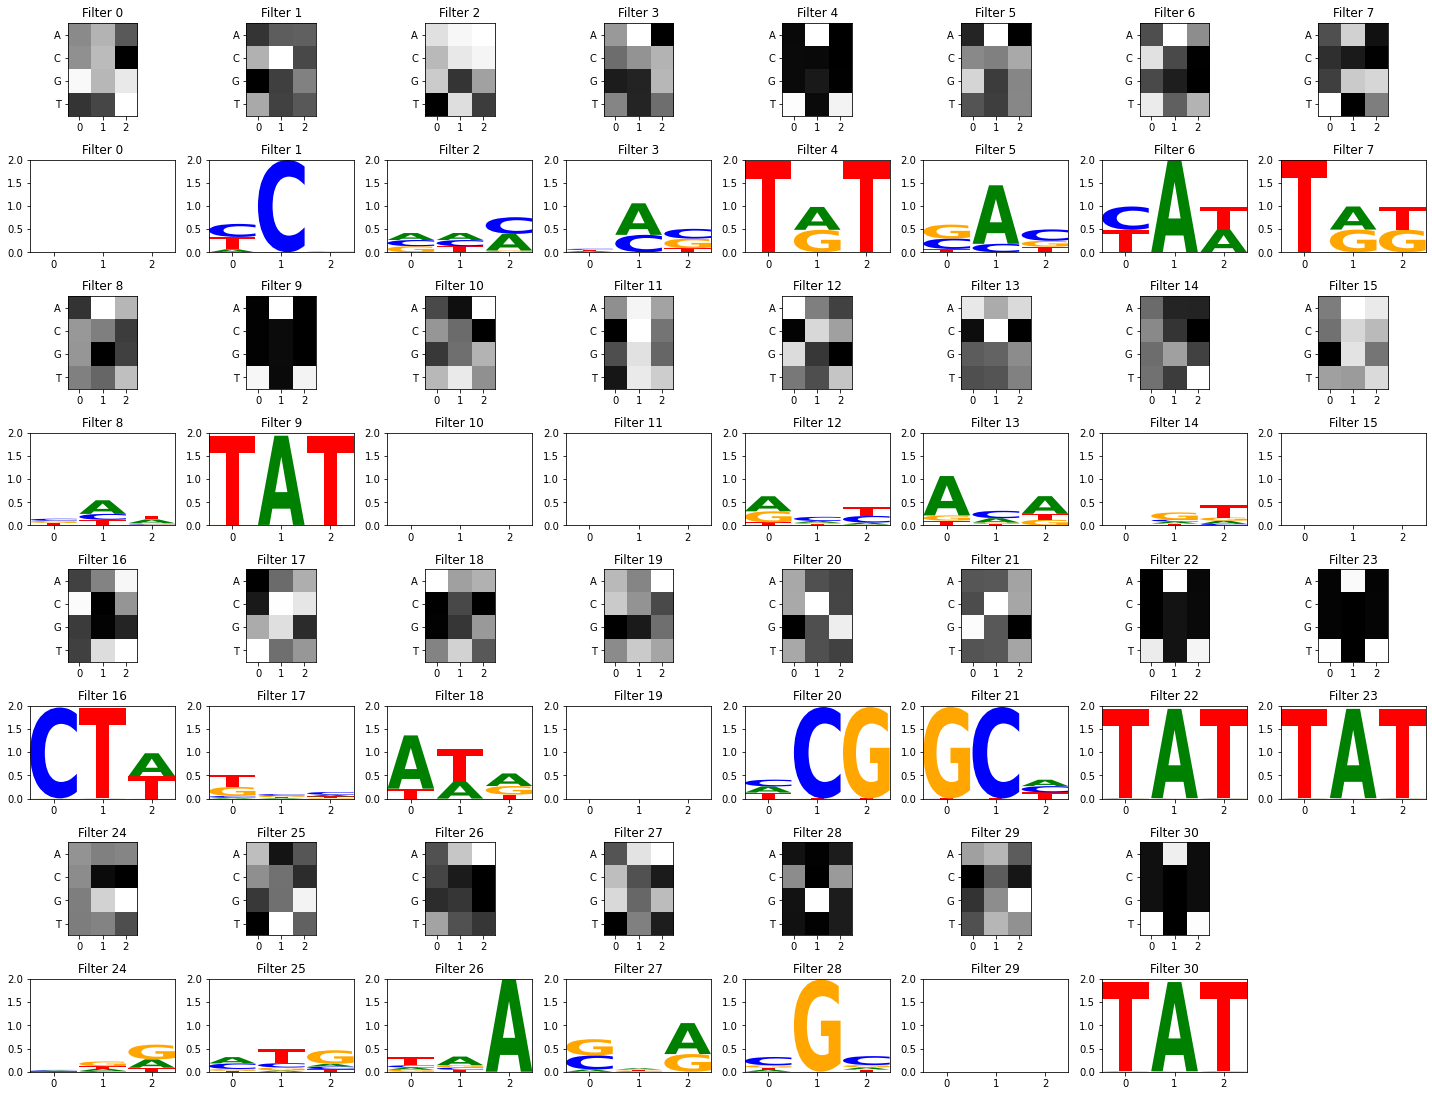

In [52]:
view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
# mer8motif_train_dl,\
# mer8motif_test_dl, \
# mer8motif_train_df, \
# mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [56]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim).to(device), 
                        torch.zeros(1, batch_size, self.hidden_dim).to(device))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [57]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm.to(device)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 6.260159874834555
1 0.4496247885378716
2 0.16716840660138704
3 0.14072362282863332
4 0.09278451318380547
5 0.06707288449056627
6 0.05554063760076965
7 0.049598241726639646
8 0.04401551350474592
9 0.04058236211508758
10 0.03338368776578912
11 0.033038280472700216
12 0.02830174467479483
13 0.02681118899403293
14 0.028525896199216097
15 0.024077181333923517
16 0.023232243443398175
17 0.020895900246874804
18 0.019443034697372352
19 0.020847224560822025


In [59]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.909 actual:20.000 (0.091)
CCCCCCCC: pred:16.879 actual:17.000 (0.121)
GGGGGGGG: pred:12.330 actual:14.000 (1.670)
TTTTTTTT: pred:10.912 actual:11.000 (0.088)

AACCAACA: pred:18.890 actual:18.875 (-0.015)
CCGGCGCG: pred:5.398 actual:5.500 (0.102)
GGGTAAGG: pred:15.167 actual:15.125 (-0.042)
TTTCGTTT: pred:12.099 actual:12.125 (0.026)
TGTAATAC: pred:15.643 actual:15.500 (-0.143)

TATAAAAA: pred:27.015 actual:27.750 (0.735)
CCTATCCC: pred:25.709 actual:25.875 (0.166)
GTATGGGG: pred:24.107 actual:24.000 (-0.107)
TTTATTTT: pred:22.688 actual:22.125 (-0.563)

AAGCGAAA: pred:7.827 actual:8.125 (0.298)
CGCGCCCC: pred:6.565 actual:6.250 (-0.315)
GGGCGGGG: pred:4.407 actual:4.375 (-0.032)
TTGCGTTT: pred:2.620 actual:2.500 (-0.120)

ATATGCGA: pred:16.438 actual:15.875 (-0.563)
TGCGTATT: pred:14.069 actual:13.625 (-0.444)



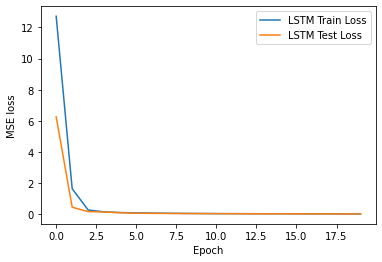

In [60]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

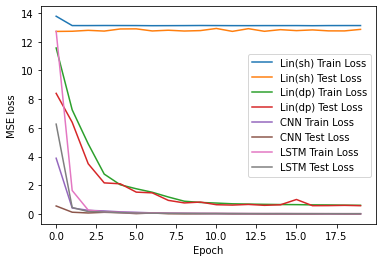

In [62]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [63]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim).to(device), 
                        torch.zeros(1, batch_size, self.hidden_dim).to(device))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [64]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm.to(device)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 0.07196659167053625
1 0.031667309376102216
2 0.017119646810827453
3 0.011509698197438285
4 0.008992252712792935
5 0.007147299186262974
6 0.0057655125174186925
7 0.005108086138684011
8 0.004080067886267188
9 0.003953143811440021
10 0.003432509028998286
11 0.0030785402910923003
12 0.0028664747383019555
13 0.0025103538767436255
14 0.0024313272653820207
15 0.002229692030768827
16 0.0022397079033929733
17 0.0020456290811754004
18 0.00197046722455099
19 0.001859434334366321


AAAAAAAA: pred:19.967 actual:20.000 (0.033)
CCCCCCCC: pred:17.006 actual:17.000 (-0.006)
GGGGGGGG: pred:13.971 actual:14.000 (0.029)
TTTTTTTT: pred:10.942 actual:11.000 (0.058)

AACCAACA: pred:18.863 actual:18.875 (0.012)
CCGGCGCG: pred:5.509 actual:5.500 (-0.009)
GGGTAAGG: pred:15.146 actual:15.125 (-0.021)
TTTCGTTT: pred:12.164 actual:12.125 (-0.039)
TGTAATAC: pred:15.470 actual:15.500 (0.030)

TATAAAAA: pred:27.455 actual:27.750 (0.295)
CCTATCCC: pred:25.907 actual:25.875 (-0.032)
GTATGGGG: pred:23.904 actual:24.000 (0.096)
TTTATTTT: pred:22.148 actual:22.125 (-0.023)

AAGCGAAA: pred:8.028 actual:8.125 (0.097)
CGCGCCCC: pred:6.278 actual:6.250 (-0.028)
GGGCGGGG: pred:4.406 actual:4.375 (-0.031)
TTGCGTTT: pred:2.617 actual:2.500 (-0.117)

ATATGCGA: pred:15.830 actual:15.875 (0.045)
TGCGTATT: pred:13.563 actual:13.625 (0.062)



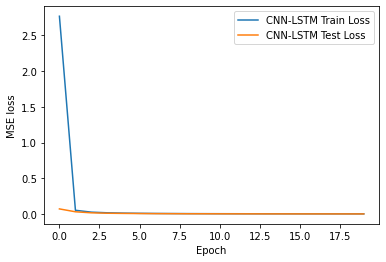

In [66]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

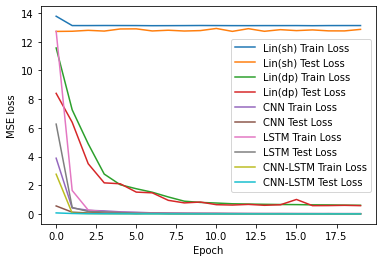

In [67]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


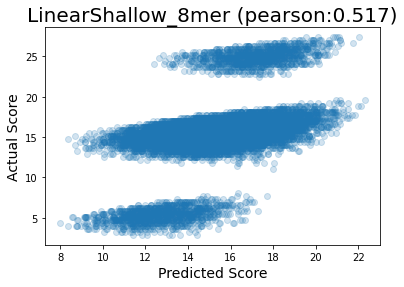

Running LinearDeep_8mer


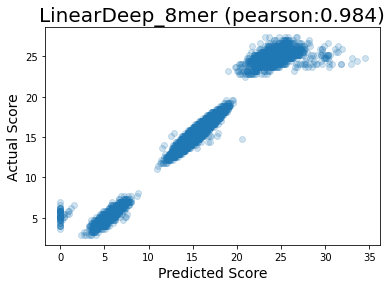

Running CNN_8mer


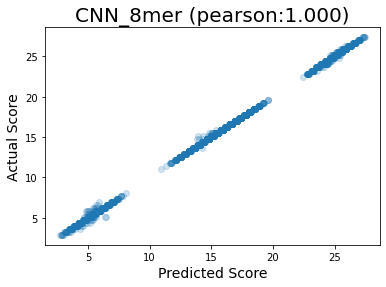

Running LSTM_8mer


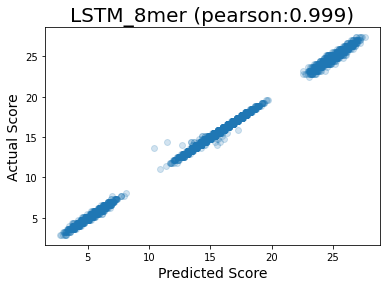

Running CNN+LSTM_8mer


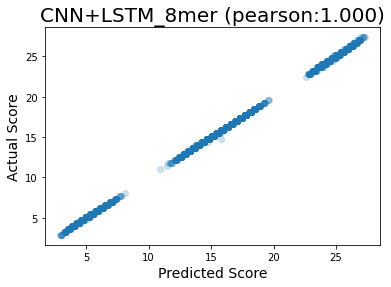

In [68]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

#dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)
dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)